# Baryonic Modules in pyCCL

An example notebook on how to use [baryonic models package](https://ccl.readthedocs.io/en/latest/api/pyccl.baryons.html) that was implemented in pyCCL v3.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
import numpy as np
import pyccl as ccl
print(f"I am using pyCCL version {ccl.__version__}")

I am using pyCCL version 3.2


Initialisation of cosmology object and scales

In [2]:
cosmology_vanilla = ccl.CosmologyVanillaLCDM()  # cosmology object
k = np.logspace(-3, 1, 100)  # wavenumber
a = 1.  # scale factor a z=0

## Construct Power Spectra $P_k$

Construct the nonlinear $P_k$ without baryonic boost

In [3]:
# Compute the nonlinear power spectra, no baryons
# note that this is using halofit
pk_nonlin = ccl.nonlin_matter_power(cosmology_vanilla, k, a)

Dark matter only $P_K$ from the Mira-Titan emulator

In [4]:
emulator_mt = ccl.CosmicemuMTIVPk("tot")  # nonlinear power spectrum emulator for CosmicEmu (Mira-Titan IV)
cosmology_dm = ccl.CosmologyVanillaLCDM(matter_power_spectrum=emulator_mt)  # cosmology object
pk_dm = cosmology_dm.nonlin_matter_power(k, a)  # dark matter only power spectrum

HMCode (through CAMB). See [Mead+20](https://arxiv.org/abs/2009.01858) for more information.

In [5]:
cosmology_hmcode = ccl.CosmologyVanillaLCDM(
   matter_power_spectrum="camb",
   extra_parameters={"camb": {"kmax": 20.0,
                               "halofit_version": "mead2020_feedback",
                               "HMCode_logT_AGN": 7.8}}
)
pk_hmcode = cosmology_hmcode.nonlin_matter_power(k, a)

Baryon Correction Model (Schneider et al. 2015). See [Schneider+ 15](https://arxiv.org/abs/1510.06034) for more information.

In [6]:
bcm = ccl.baryons.BaryonsSchneider15()  # baryonic correction model
pk_bcm_boost = bcm.include_baryonic_effects(
    cosmo=cosmology_vanilla,
    pk=cosmology_vanilla.get_nonlin_power()
)
pk_bcm = pk_bcm_boost(k, a)

BACCOemu $P_k$. For more information about BACCOemu, see [Aricò+ 20](https://arxiv.org/abs/2011.15018).

This is an emulator option built on top of the “baryonification” strategy (moving particles in DMO sims to represent baryonic feedback scenarios). This is not full hydro but it reproduces hydro sims well (1-2%). Note that include_baryonic_effects will not work on BACCO (the issue was that `include_baryonic_effects` tries to apply the correction over the whole internal k and a range and bacco doesn't cover the same range).

In [7]:
baccoemu = ccl.BaccoemuBaryons()
cosmology_baccoemu = ccl.CosmologyVanillaLCDM()
bacco_boost = baccoemu.boost_factor(cosmology_baccoemu, k, a)
pk_bacco = cosmology_baccoemu.nonlin_matter_power(k, a) * bacco_boost

2025-03-13 17:39:02.686474: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Van Daalen boosted $P_k$. For more information, see [Van Daalen+ 2019](https://arxiv.org/abs/1906.00968).

In [8]:
vd = ccl.baryons.BaryonsvanDaalen19()  # Van Daalen 2019
boost_pk_vd = vd.include_baryonic_effects(
   cosmo=cosmology_vanilla,
    pk=cosmology_vanilla.get_nonlin_power()
)
pk_vd = boost_pk_vd(k, a)

## Plot results

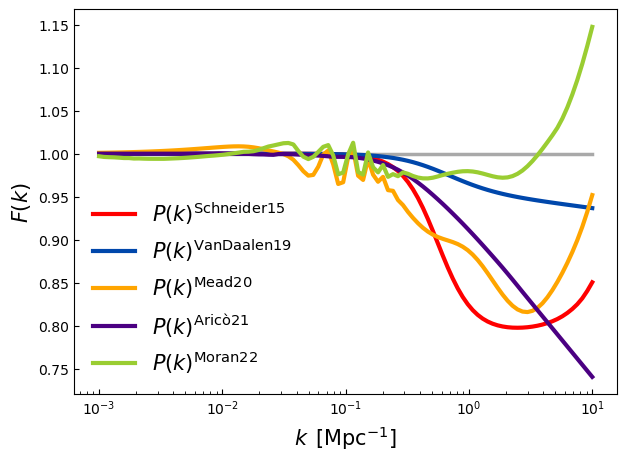

In [9]:
# List of vivid colors
colors = [
    "#FF0000",  # Vivid Red
    "#0047AB",  # Royal Blue
    "#FFA500",  # Vivid Orange
    "#4B0082",  # Indigo
    "#9ACD32",  # Yellow Green
    "#FF00FF"   # Magenta
]

# List of pk data and their labels
pk_data = [
    (pk_bcm/pk_nonlin, r"$P(k)^\mathrm{Schneider 15}$"),
    (pk_vd/pk_nonlin, r"$P(k)^\mathrm{Van Daalen 19}$"),
    (pk_hmcode/pk_nonlin, r"$P(k)^\mathrm{Mead 20}$"),
    (pk_bacco/pk_nonlin, r"$P(k)^\mathrm{Aricò 21}$"),
    (pk_dm/pk_nonlin, r"$P(k)^\mathrm{Moran22}$"),
]

# Set the figure size
plt.figure(figsize=(7, 5))
# Add the reference line for pk_nonlin / pk_nonlin = 1
plt.semilogx(k, [1]*len(k), c="darkgray", lw=2.5)  # Using darkgray color for the reference line

# Loop over the pk data and colors to plot them
for (pk, label), color in zip(pk_data, colors):
    plt.semilogx(k, pk, c=color, label=label, lw=3)

# Setting the properties for ticks, labels, and legend
plt.gca().tick_params(direction='in', which='both')  
plt.xlabel(r"$k \: \: \mathrm{[Mpc^{-1}]}$", fontsize=15)
plt.ylabel(r"$F (k)$", fontsize=15)

# Change y-axis labels to standard notation
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.legend(frameon=False, fontsize=15)
plt.show()
